# AUV 2D

In [1]:
import sys
sys.path.append("../src")
from imperium.dynamics.symbolic import System
from sympy import *
init_printing()

In [2]:
# state
x, y, vx, vy = Matrix(symbols('x y v_x v_y', real=True))
state = Matrix([x, y, vx, vy])

# control
ut, ux, uy = symbols('u_t', real=True, nonnegative=True), *symbols('u_x u_y', real=True)
control = Matrix([ut, ux, uy])

# constant system parameters
CD, m, A, T, rho = symbols('C_D m A T rho', real=True, nonnegative=True)
sysparams = Matrix([T, m])

# state dynamics
dynamics = Matrix([
    vx,
    vy,
    T*ut*ux/m,
    T*ut*uy/m
])

# optimisation parameters
alpha = symbols('alpha', real=True, nonnegative=True)
optparams = [alpha]

# Lagrangian
lagrangian = alpha*ut + (1 - alpha)*ut**2

# equality constraints
equality = Matrix([sqrt(ux**2 + uy**2) - 1])

# inequality constraints
inequality = Matrix([ut-1, -ut, ux-1, -1-ux, uy-1, -1-uy])

# define nondimensional parameters
tb, lb, mb = symbols('t_b l_b m_b')
ndunits = [tb, lb, mb]

# dimensional transformations
trans = Matrix([lb, lb, lb/tb, lb/tb])
tranp = Matrix([mb*lb/tb**2, mb])

In [3]:
# instantiate the system
sys = System(state, control, dynamics, lagrangian, sysparams, optparams, ndunits, trans, tranp)
sys.dfs.T

⎡         T⋅uₜ⋅uₓ  T⋅uₜ⋅u_y                 ⎤
⎢vₓ  v_y  ───────  ────────  0  0  -λₓ  -λ_y⎥
⎣            m        m                     ⎦

In [4]:
# optimal thrust direction (solved by hand with geometric method)
utheta = -Matrix([sys.l[2], sys.l[3]])/sqrt(sys.l[2]**2 + sys.l[3]**2)
utheta.T

⎡       -λᵥ ₓ               -λ_v_y       ⎤
⎢───────────────────  ───────────────────⎥
⎢   ________________     ________________⎥
⎢  ╱     2        2     ╱     2        2 ⎥
⎣╲╱  λᵥ ₓ  + λ_v_y    ╲╱  λᵥ ₓ  + λ_v_y  ⎦

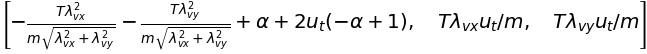

In [5]:
# gradient of Hamiltonian
sys.KKT([(ux, utheta[0]), (uy, utheta[1])])
sys.KKTeqs

In [6]:
# solving
sol = solve(sys.KKTeqs, sys.KKTvars, simplify=True, force=True)

In [7]:
# now assign optimal controls
sys.uo = Matrix([[sol[ut]], utheta])
sys.uo.T

⎡                              ________________                               
⎢        2          2         ╱     2        2                                
⎢- T⋅λᵥ ₓ  - T⋅λ_v_y  + α⋅m⋅╲╱  λᵥ ₓ  + λ_v_y           -λᵥ ₓ               -λ
⎢──────────────────────────────────────────────  ───────────────────  ────────
⎢                      ________________             ________________     _____
⎢                     ╱     2        2             ╱     2        2     ╱     
⎣       2⋅m⋅(α - 1)⋅╲╱  λᵥ ₓ  + λ_v_y            ╲╱  λᵥ ₓ  + λ_v_y    ╲╱  λᵥ ₓ

           ⎤
           ⎥
_v_y       ⎥
───────────⎥
___________⎥
2        2 ⎥
  + λ_v_y  ⎦

In [8]:
sys.ndimp

⎡      2⎤
⎢ T⋅t_b ⎥
⎢───────⎥
⎢l_b⋅m_b⎥
⎢       ⎥
⎢   m   ⎥
⎢  ───  ⎥
⎣  m_b  ⎦

In [10]:
# make some fortran code!
sys.codegen("../src/imperium/dynamics/fortran/auv2d", "F")

# Using fortran code

In [11]:
import sys
sys.path.append("../src")
from imperium.dynamics import auv2d
from imperium.segment import Indirect
import numpy as np, matplotlib.pyplot as plt
%matplotlib

ModuleNotFoundError: No module named 'pygmo'

In [ ]:
# instantiate segment
seg = Indirect(auv2d, [10, 10], [100, 10, 100], [0, -1, -1], [1, 1, 1], True)

In [ ]:
# set boundaries
seg.set(0, np.array([0, 0, 0, 0]), 100, np.array([10, 10, 0, 0]), np.random.random(4)*100, [0.99], True)

In [ ]:
# integrate
seg.propagate(atol=1e-15, rtol=1e-15)

In [ ]:
fig, ax = plt.subplots(8)

for i in range(8):
    ax[i].plot(seg.times, seg.states[:, i], "k.-")
    
plt.show()

In [ ]:
fig, ax = plt.subplots(3)

for i in range(3):
    ax[i].plot(seg.times, seg.controls[:, i], "k.-")
    
plt.show()

In [ ]:
ceq = seg.mismatch(norm=True)

In [ ]:
ceq/np.linalg.norm(ceq)

In [ ]:
fs = np.array([5, 5, 5, 5, 10, 10, 10, 10])
s = fs[:int(len(fs)/2)]
l = fs[int(len(fs)/2):]
l

In [ ]:
np.normalize